## Imports

In [11]:
import rospy
from actionlib import SimpleActionClient
import assignment_2_2022.msg
import assignment_rt1_2.msg
from nav_msgs.msg import Odometry
import assignment_rt1_2.srv
import ipywidgets as widgets
from threading import Thread
from math import sqrt
import matplotlib.pyplot as plt
#from time import sleep
#from jupyros.ros1 import ros3d


## Controller

In [12]:
class Controller:
    
    def __init__(self, goal_x: float = 0, goal_y: float = 0, r: int = 5) -> None:
        # Variables
        self.x = 0
        self.y = 1
        self.vel_x = 0
        self.vel_y = 0
        self.goal_x = goal_x
        self.goal_y = goal_y
        self.r = rospy.Rate(r)
        self.finished = False
        self.cancelled = False
        self.status_msg = assignment_rt1_2.msg.RobotStatus()
        self.status_msg.goal_x = self.goal_x
        self.status_msg.goal_y = self.goal_y
        self.gr = 0
        self.gc = 0
        self.x_hist = []
        self.y_hist = []
        self.hist_threshold = .001
        
        # Action client
        self.action_client = SimpleActionClient("/reaching_goal", assignment_2_2022.msg.PlanningAction)
        print("Waiting for action server.")
        self.action_client.wait_for_server()
        print("Action server started.")
        
        # Publisher
        self.pub = rospy.Publisher("/robot/status", assignment_rt1_2.msg.RobotStatus, queue_size=10)
        
        # Subscriber
        rospy.Subscriber("/odom", Odometry, self.get_status)
        
        # Service client
        self.service = rospy.ServiceProxy("/goals", assignment_rt1_2.srv.Goals)
     
        
    def get_status(self, msg: Odometry):
        
        # Update variables
        self.x = msg.pose.pose.position.x
        self.y = msg.pose.pose.position.y
        self.vel_x = msg.twist.twist.linear.x
        self.vel_y = msg.twist.twist.linear.y
        if len(self.x_hist) == 0 or abs(self.x_hist[-1] - self.x) > self.hist_threshold or \
        len(self.y_hist) == 0 or abs(self.y_hist[-1] - self.y) > self.hist_threshold:
            self.x_hist.append(self.x)
            self.y_hist.append(self.y)
            
        
        # Change robot status msg
        self.status_msg.x = self.x
        self.status_msg.y = self.y
        self.status_msg.vel_x = self.vel_x
        self.status_msg.vel_y = self.vel_y
        
    
    def send_goal(self, x: float = None, y: float = None):
        self.finished = False
        
        if x is not None:
            self.goal_x = x
            self.status_msg.goal_x = x
        if y is not None:
            self.goal_y = y
            self.status_msg.goal_y = y
        
        goal = assignment_2_2022.msg.PlanningGoal()
        goal.target_pose.pose.position.x = self.goal_x
        goal.target_pose.pose.position.y = self.goal_y
        
        self.action_client.send_goal(goal)
        print("Goal sent.")
        self.cancelled = False
        # self.spin()
        thread = Thread(target=self.spin)
        thread.start()
        
    
    def spin(self):
        self.finished = self.action_client.wait_for_result(self.r.remaining())
        while (not self.finished and not rospy.is_shutdown()):
            
            # rospy default behaviour is to spinOnce in a while loop.
            self.pub.publish(self.status_msg)
            
            # Wait for finish status
            self.finished = self.action_client.wait_for_result(self.r.remaining())
        
        if not self.cancelled:
            print("Goal reached.")
            self.gr += 1
            rospy.set_param("/goals_reached", self.gr)
            
        # Call service
        # self.service.call(assignment_rt1_2.srv.GoalsRequest())
        
            
    def cancel(self):
        self.action_client.cancel_goal()
        self.cancelled = True
        print("Goal cancelled.")
        self.gc += 1
        rospy.set_param("/goals_cancelled", self.gc)
        
        
    def get_goals(self):
        return self.gr, self.gc
    
    
    def get_position(self):
        return self.x, self.y
    
    
    def get_dist(self):
        return sqrt((self.x - self.goal_x)**2 + (self.y - self.goal_y)**2)

## Interactive Widgets

In [13]:
# Initialize node
rospy.init_node("Node_A")

# Goal position using float text boxes
gx = widgets.FloatText(
    value=4,
    description="Goal x position:",
    disabled=False,
    continuous_update=False
)

gy = widgets.FloatText(
    value=-5,
    description="Goal y position:",
    disabled=False,
    continuous_update=False
)

# Send/Cancel goal using a toggle button
send_button = widgets.ToggleButton(
    value=False,
    description="Run",
    disabled=False,
    tooltip="The robot goes to the goal while the button is toggled.",
    button_style="",
    icon="compass"
)

cancel_button = widgets.Button(
    value=False,
    description="Cancel",
    disabled=True,
    tooltip="Cancel current goal.",
    button_style="",
    icon="cross"
)

# Initialize controller
cont = Controller()

def wait_for_cont():
    while not cont.finished:
        pass
    send_button.value = False
    send_button.disabled = False
    cancel_button.disabled = True
    

def toggle(change):
    if change["new"]:
        send_button.disabled = True
        cancel_button.disabled = False
        cont.send_goal(gx.value, gy.value)
        thread = Thread(target=wait_for_cont)
        thread.start()
        

        
def cancel_goal(b):
    cont.cancel()
    cancel_button.disabled = True


# Observe changes in the button
send_button.observe(toggle, "value")
cancel_button.on_click(cancel_goal)


interactive_widgets = widgets.HBox([widgets.VBox([gx, gy]), widgets.VBox([send_button, cancel_button])])

Waiting for action server.
Action server started.


Goal sent.
Goal cancelled.


## Display Widgets

### HTML Displays

In [14]:
title = widgets.HTML(value="<h1>Robot parameters</h1>")
robot_position_display = widgets.HTML(value=f"<b>Robot position:</b> ({cont.x:.1f}, {cont.y:.1f})")
distance_display = widgets.HTML(value="<b>Distance to goal:</b> 0")
gr_display = widgets.HTML(value="<b>Number of goals reached:</b> 0")
gc_display = widgets.HTML(value="<b>Number of goals cancelled:</b> 0")

### UI

In [15]:
ui = widgets.VBox([title, robot_position_display, distance_display, gr_display, gc_display, interactive_widgets])
display(ui)

## Path Visualization

Text(0, 0.5, 'y')

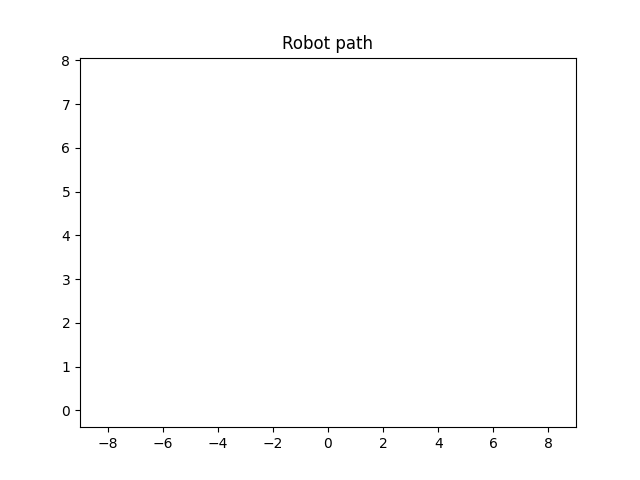

IndexError: list index out of range

IndexError: list index out of range

Exception in thread Thread-21:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_24633/1664460444.py", line 4, in update_position
  File "/tmp/ipykernel_24633/4048146058.py", line 15, in update_graph
  File "/home/lucas/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/home/lucas/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/home/lucas/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
ValueError: x and y must have same first dimension, but have shapes (192,) and (193,)


IndexError: list index out of range

In [16]:
%matplotlib widget

fig, ax = plt.subplots()
ax.set_xlim((-9, 9))
ax.set_ylim((-9, 9))
ax.set_title("Robot path")
ax.set_xlabel("x")
ax.set_ylabel("y")

## Update Functions

Start the update functions in different threads.

### Update Graph

In [17]:
def update_graph(x, y):
    # Clear graph
    ax.clear()
    # Configure axis
    ax.set_xlim((-9, 9))
    ax.set_ylim((-9, 9))
    ax.set_title("Robot path")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # Plot goal
    ax.plot(cont.goal_x, cont.goal_y, "go", markersize=10)
    # Plot robot
    ax.plot(x, y, "bx", markersize=10)
    # Plot robot path
    ax.plot(cont.x_hist, cont.y_hist, "k", linewidth=0.8)

### Update Position

In [18]:
def update_position():
    while not rospy.is_shutdown():
        x, y = cont.get_position()
        update_graph(x, y)
        robot_position_display.value = f"<b>Robot position:</b> ({x:.2f}, {y:.2f})"
        rospy.sleep(0.5)

thread = Thread(target=update_position)
thread.start()

### Update Distance

In [19]:
def update_distance():
    while not rospy.is_shutdown():
        d = cont.get_dist()
        distance_display.value = f"<b>Distance to goal:</b> {d:.2f}"
        rospy.sleep(0.5)

thread = Thread(target=update_distance)
thread.start()

### Update Goals

In [20]:
def update_goals():
    while not rospy.is_shutdown():
        gr, gc = cont.get_goals()
        gr_display.value = f"<b>Number of goals reached:</b> {gr:.2f}"
        gc_display.value = f"<b>Number of goals cancelled:</b> {gc:.2f}"
        rospy.sleep(0.5)

thread = Thread(target=update_goals)
thread.start()